In [75]:
!pip install librosa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [76]:
!pip install surfboard

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [77]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

import seaborn as sns

from sklearn import preprocessing

from sklearn.model_selection import train_test_split

import librosa
import librosa.display
import IPython.display


from google.colab import drive

from tqdm import tqdm

from surfboard import feature_extraction
# from data.features import load_spectrogram

In [78]:
!pip install openl3
import openl3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [79]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


EDA on audio files

In [80]:
song_path = '/content/drive/MyDrive/Colab Notebooks/Project/pneumonia_files/audio_files/20190128-145230-45be2b1a85adc726-chest03.wav'
signal,sample_rate = librosa.load(song_path)

In [81]:
signal.shape

(295911,)

In [82]:
signal

array([ 5.85282396e-05,  1.18588883e-04,  1.92790190e-04, ...,
       -1.14588905e-02, -8.25630128e-03, -4.04791813e-03], dtype=float32)

In [83]:
IPython.display.Audio(signal, rate=sample_rate)

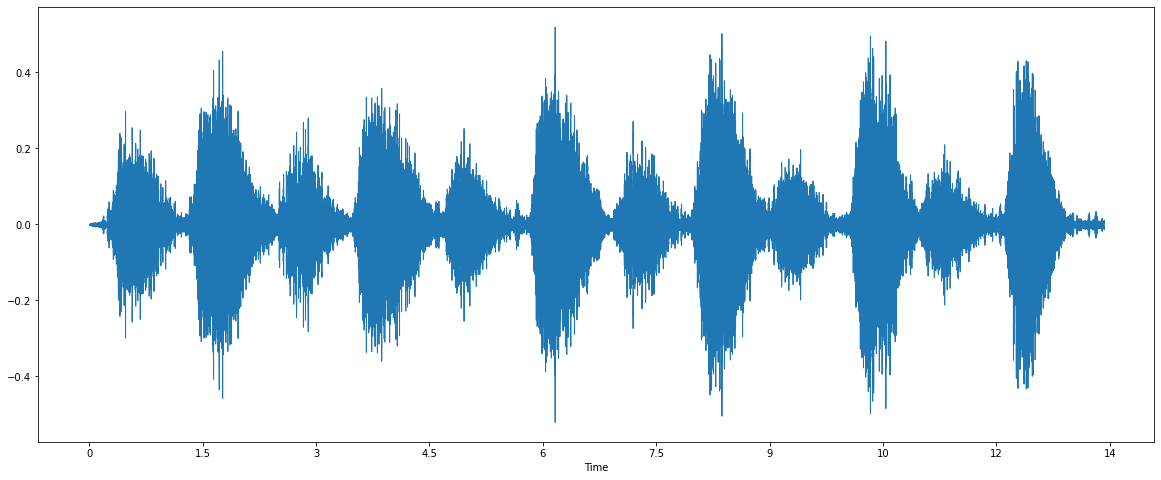

In [84]:
plt.figure(figsize = (20,8))
librosa.display.waveshow(signal,sr=sample_rate)
plt.show();

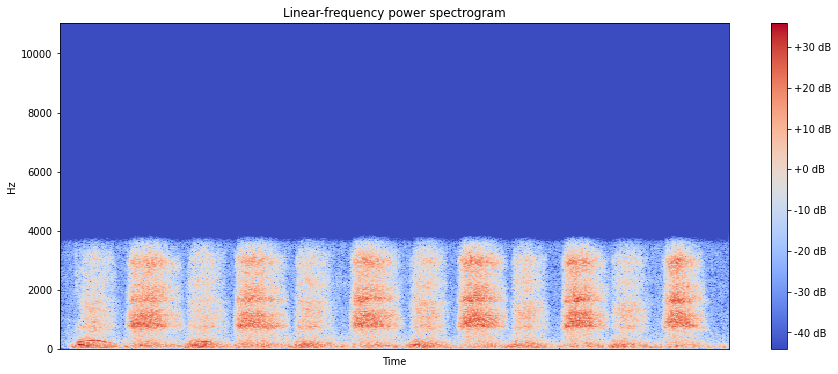

In [85]:
plt.figure(figsize=(15, 6))
decibels = librosa.amplitude_to_db(np.abs(librosa.stft(signal)))
# amplitude_to_db converts an amplitude spectrogram to dB-scaled spectrogram
librosa.display.specshow(decibels, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.xlabel('Time')
plt.title('Linear-frequency power spectrogram')
plt.show()

In [86]:
mfccs = librosa.feature.mfcc(signal, sr=sample_rate)
mfccs.shape


(20, 578)

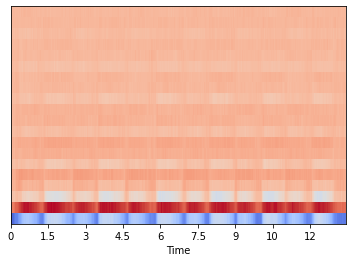

In [87]:
librosa.display.specshow(mfccs, sr=sample_rate, x_axis='time');

In [88]:
mfccs = preprocessing.scale(mfccs, axis=1)
print(mfccs.mean(axis=1))
print(mfccs.var(axis=1))

[-1.6499556e-09  1.3199645e-08 -1.1549689e-08  1.3199645e-08
  1.3199645e-08 -6.5998225e-09  1.3199645e-08  4.9498667e-09
 -1.3199645e-08 -4.9498667e-09  6.5998225e-09 -1.3199645e-08
  0.0000000e+00  6.5998225e-09 -1.3199645e-08 -3.2999112e-09
 -6.5998225e-09 -3.2999112e-09 -6.5998225e-09  0.0000000e+00]
[1.         1.0000001  1.         1.         1.0000001  1.
 1.0000001  1.0000001  1.0000001  1.0000001  1.         1.
 1.         1.0000001  1.0000002  1.         1.         0.9999999
 1.         0.99999976]


/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_data.py:240: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_data.py:259: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


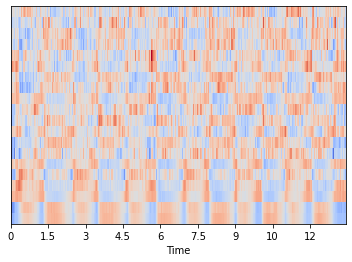

In [89]:
librosa.display.specshow(mfccs, sr=sample_rate, x_axis='time');

The MFCC transformation actially gives 20 rows of features and columns are the their values in time

In [90]:
mfccs.T.shape

(578, 20)

**!!! Insert cleansing part**

dataframe with all paths to audio files and meta data (cleaned by model)

In [91]:
df_files = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project/selected_records.csv')

In [92]:
df_files.shape

(1762, 12)

In [93]:
df_files.sample(5)

,Unnamed: 0,id,path,point,time,model,label,duration,rec_id,n_seg,length,predicted_label
773,2428,6a18a5e8e9ac8272,./audio_files/20210701-103426-6a18a5e8e9ac8272...,chest03,20210701-103426,Xiaomi Redmi Note 9 Pro | 10,problems,6.528,6a18a5e8e9ac8272_chest03,1,6.272608,True
733,2378,e2dbece695e619c9,./audio_files/20210607-121141-e2dbece695e619c9...,chest03,20210607-121141,Xiaomi Mi A2 | 10,problems,6.784,e2dbece695e619c9_chest03,1,6.575057,True
165,1363,a74c346ff7b4e09f,./audio_files/20190912-160444-a74c346ff7b4e09f...,spine06,20190912-160444,HUAWEI ANE-LX1 | 8.0.0,problems,17.920,a74c346ff7b4e09f_spine06,1,17.687800,True
849,2529,7b618637e3f9b1e7,./audio_files/20210705-110639-7b618637e3f9b1e7...,chest04,20210705-110639,Xiaomi Redmi Note 9 Pro | 10,problems,3.328,7b618637e3f9b1e7_chest04,1,3.026168,True
618,2234,9ba6581ed461cd5f,./audio_files/20210518-102853-9ba6581ed461cd5f...,spine04,20210518-102853,Xiaomi Redmi Note 9 Pro | 10,problems,5.632,9ba6581ed461cd5f_spine04,3,4.876190,True


In [94]:
df_files['label'].value_counts()

problems    1146
normal       616
Name: label, dtype: int64

In [95]:
display(df_files.isna().sum(axis=0).sort_values(ascending = False).head(4))
df_files.isna().sum(axis=1).value_counts()

Unnamed: 0    0
id            0
path          0
point         0
dtype: int64

0    1762
dtype: int64

encoding the target to 0/1

In [96]:
df_files['target'] = 0
df_files.loc[df_files[df_files['label'] == 'problems'].index,'target'] = 1

In [97]:
df_files['target'].value_counts()

1    1146
0     616
Name: target, dtype: int64

Date-time conversion

In [98]:
df_files['Date'] = df_files['time'].str.slice(start=0, stop=8)
df_files['Time'] = df_files['time'].str.slice(start=9, stop=11) + ':' + df_files['time'].str.slice(start=11, stop=13)


In [99]:
# Convert the date and time components into a datetime object
df_files['Datetime'] = pd.to_datetime(df_files['Date'].astype(str) + ' ' + df_files['Time'], format='%Y%m%d %H:%M')

# Drop the intermediate date and time columns and display the resulting DataFrame
df_files.drop(['time', 'Date', 'Time'], axis=1, inplace=True)

In [100]:
df_files[df_files['Datetime'] < '2019-08-14'] # as we were told these are to be deleted

,Unnamed: 0,id,path,point,model,label,duration,rec_id,n_seg,length,predicted_label,target,Datetime


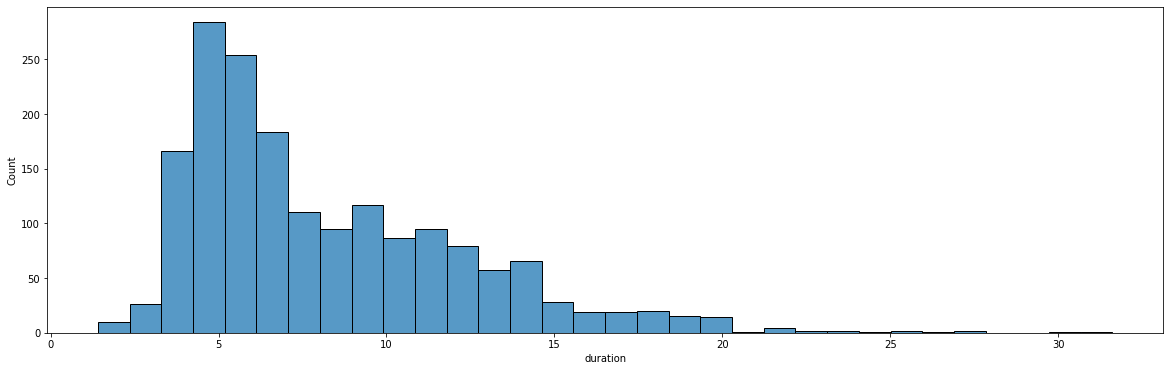

In [101]:
import seaborn as sns
fig = plt.figure(figsize=(20,6))
sns.histplot(df_files['duration']);

Additionally checked files appeared - need to check the labels and adjust

In [102]:
df_positive = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project/positives.csv', header=None)
df_negative = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project/negatives.csv', header=None)

In [103]:
df_positive = './audio_files/' +  df_positive[0].str.lstrip('http://lungs.makseq.com/data/service/')
df_negative = './audio_files/' +  df_negative[0].str.lstrip('http://lungs.makseq.com/data/service/')
df_positive

0      ./audio_files/20211101-125147-b5a05864b4f448a1...
1      ./audio_files/20211101-125147-b5a05864b4f448a1...
2      ./audio_files/20211101-125147-b5a05864b4f448a1...
3      ./audio_files/20211029-100738-0657eaa451ac2742...
4      ./audio_files/20211029-100738-0657eaa451ac2742...
                             ...                        
145    ./audio_files/20210915-140850-d594cbe6e2461128...
146    ./audio_files/20210916-115907-e56a0cb1b234b74f...
147    ./audio_files/20210916-115907-e56a0cb1b234b74f...
148    ./audio_files/20210916-115907-e56a0cb1b234b74f...
149    ./audio_files/20210916-115907-e56a0cb1b234b74f...
Name: 0, Length: 150, dtype: object

In [104]:
df_files[df_files['path'].isin(df_positive)]['target'].sum()

146

In [105]:
df_files[df_files['path'].isin(df_negative)]['target'].sum()

34

These labels to adjust:

In [106]:
df_files.loc[df_files['path'].isin(df_positive), 'target'] = 1
df_files.loc[df_files['path'].isin(df_negative), 'target'] = 0

these "good" ones have to be stratified for train-test split

In [107]:
df_files['isgood'] = 0
df_files.loc[df_files['path'].isin(df_negative), 'isgood'] = 1
df_files.loc[df_files['path'].isin(df_positive), 'isgood'] = 2

In [108]:
df_files['isgood'].value_counts()

0    1462
1     152
2     148
Name: isgood, dtype: int64

We delete rows that are shorter than 2 sec and rows where the file couldn't be read:

In [109]:
threshold = 2
delete_index = []
errors = 0

for i, row in tqdm(df_files.iterrows(), total=len(df_files['path'])):
    path = '/content/drive/MyDrive/Colab Notebooks/Project/pneumonia_files' + df_files.loc[i]['path'].lstrip('.')
    signal,sample_rate = librosa.load(path)
    if signal.sum() == 0:
      # print('zero  ', path)
      delete_index.append(i)
    else: 
      try:
        if librosa.get_duration(signal, sample_rate) < threshold:
          delete_index.append(i)
      except:
        errors += 1
        delete_index.append(i)

100%|██████████| 1762/1762 [08:53<00:00,  3.30it/s]


In [110]:
len(delete_index)

6

In [111]:
df_files.shape

(1762, 14)

In [112]:
df_files = df_files.drop(delete_index)

In [113]:
df_files.shape

(1756, 14)

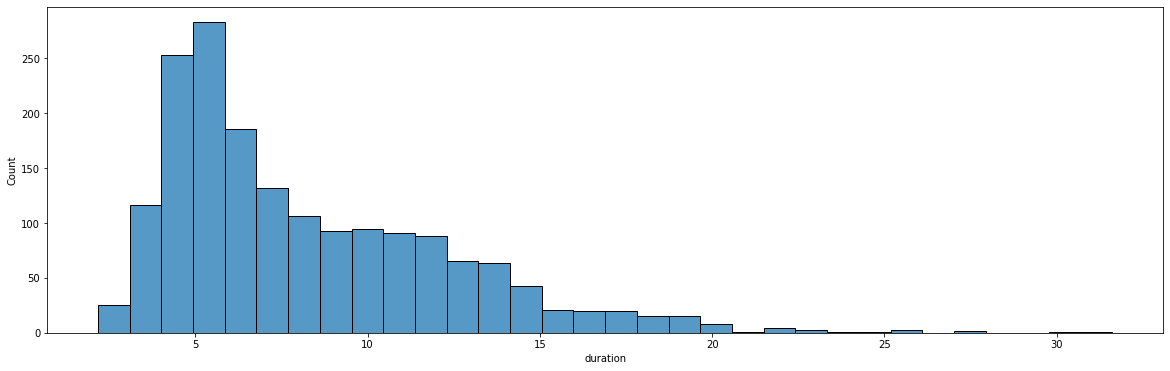

In [114]:
import seaborn as sns
fig = plt.figure(figsize=(20,6))
sns.histplot(df_files['duration']);

Split

In [115]:
features = ['id', 'model', 'Datetime', 'point', 'path', 'isgood']
df_features = df_files[features]

In [116]:
path_train, path_test, y_train, y_test = train_test_split(df_features, df_files['target'], 
                                                    test_size=0.2 ,random_state=99, stratify=df_files['isgood'])

In [117]:
path_train.shape, path_test.shape, y_train.shape, y_test.shape

((1404, 6), (352, 6), (1404,), (352,))

Write the results to disk

In [118]:
path_train.to_csv("/content/drive/MyDrive/Colab Notebooks/Project/path_train.csv")
y_train.to_csv("/content/drive/MyDrive/Colab Notebooks/Project/y_train.csv")
path_test.to_csv("/content/drive/MyDrive/Colab Notebooks/Project/path_test.csv", index=False)
y_test.to_csv("/content/drive/MyDrive/Colab Notebooks/Project/y_test.csv", index=False)

Read files from disk

In [119]:
path_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project/path_train.csv')
path_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project/path_test.csv')
y_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project/y_train.csv', usecols=['target'])
y_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project/y_test.csv', usecols=['target'])

In [120]:
y_train.head()

,target
0,1
1,1
2,1
3,1
4,1


In [121]:
path_train.head()

,Unnamed: 0,id,model,Datetime,point,path,isgood
0,469,e7dacad5835e6114,Xiaomi Mi A2 | 10,2021-04-06 10:54:00,spine04,./audio_files/20210406-105419-e7dacad5835e6114...,0
1,431,70c1ce00e5f9fa94,HUAWEI ANE-LX1 | 8.0.0,2021-03-18 16:08:00,chest04,./audio_files/20210318-160838-70c1ce00e5f9fa94...,0
2,668,72174c2362ec2988,Xiaomi Redmi Note 9 Pro | 10,2021-06-01 12:35:00,spine01,./audio_files/20210601-123507-72174c2362ec2988...,0
3,447,2e39c794afea25d7,Xiaomi Mi A2 | 10,2021-04-01 14:45:00,spine02,./audio_files/20210401-144554-2e39c794afea25d7...,2
4,1200,767927efd97ec9bc,Xiaomi Redmi Note 9 Pro | 10,2021-09-13 10:12:00,spine04,./audio_files/20210913-101254-767927efd97ec9bc...,0


In [122]:
path_train.shape

(1404, 7)

In [123]:
config = {
    'log_melspec': {
        'hop_length_seconds': 0.02,
        'n_fft_seconds': 0.08,
        'n_mels': 64,
    },
    'loudness_slidingwindow': {
        'frame_length_seconds': 1.0,
        'hop_length_seconds': 0.25
    }
}

In [124]:
path_train['path'] = '/content/drive/MyDrive/Colab Notebooks/Project/pneumonia_files' + path_train['path'].str.lstrip('.')

In [125]:
path_test['path'] = '/content/drive/MyDrive/Colab Notebooks/Project/pneumonia_files' + path_test['path'].str.lstrip('.')

In [126]:
path_test['path']

0      /content/drive/MyDrive/Colab Notebooks/Project...
1      /content/drive/MyDrive/Colab Notebooks/Project...
2      /content/drive/MyDrive/Colab Notebooks/Project...
3      /content/drive/MyDrive/Colab Notebooks/Project...
4      /content/drive/MyDrive/Colab Notebooks/Project...
                             ...                        
347    /content/drive/MyDrive/Colab Notebooks/Project...
348    /content/drive/MyDrive/Colab Notebooks/Project...
349    /content/drive/MyDrive/Colab Notebooks/Project...
350    /content/drive/MyDrive/Colab Notebooks/Project...
351    /content/drive/MyDrive/Colab Notebooks/Project...
Name: path, Length: 352, dtype: object

In [127]:
X_train = (
    feature_extraction.extract_features_from_paths(
        path_train['path'],
        components_list=[{key: config[key]} for key in config],
        statistics_list=["mean", "std"],
    )
    .replace(-np.inf, np.nan)
    .fillna(method="bfill")
)

Extracting features from paths...: 100%|██████████| 1404/1404 [15:23<00:00,  1.52it/s]


In [128]:
X_train.shape

(1404, 130)

In [129]:
X_train

,log_melspec_mean_1,log_melspec_mean_2,log_melspec_mean_3,log_melspec_mean_4,log_melspec_mean_5,log_melspec_mean_6,log_melspec_mean_7,log_melspec_mean_8,log_melspec_mean_9,log_melspec_mean_10,...,log_melspec_std_57,log_melspec_std_58,log_melspec_std_59,log_melspec_std_60,log_melspec_std_61,log_melspec_std_62,log_melspec_std_63,log_melspec_std_64,loudness_slidingwindow_mean,loudness_slidingwindow_std
0,-14.886156,-23.258303,-28.828094,-33.283867,-36.636951,-39.701885,-40.908424,-42.161259,-43.908169,-45.306477,...,0.089697,0.025798,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-30.826940,4.966494
1,-32.213253,-32.193779,-33.649742,-31.628759,-26.865906,-28.785889,-39.145168,-39.957001,-41.040249,-39.374268,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-29.924843,5.082411
2,-10.548471,-35.995289,-40.206234,-39.907600,-42.414394,-42.999485,-44.262623,-47.239292,-48.080372,-48.938839,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-29.001059,2.495189
3,-10.116969,-25.811708,-32.765472,-36.752068,-40.730591,-43.220337,-46.121777,-47.941284,-50.479698,-52.359818,...,0.961902,0.927894,0.897901,0.871928,0.850049,0.832392,0.819183,0.810846,-25.621533,2.626842
4,-21.612446,-41.789742,-48.780376,-50.776047,-52.075554,-42.817852,-46.544277,-56.328827,-56.422482,-57.386852,...,0.507351,0.480847,0.457479,0.437255,0.420216,0.406465,0.396180,0.389679,-31.011400,5.900052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1399,-11.311627,-26.875078,-32.738152,-38.310947,-43.644199,-48.355053,-51.220627,-52.676964,-54.405304,-56.412579,...,0.937697,0.905386,0.876597,0.851436,0.830049,0.812667,0.799590,0.791287,-24.178249,1.437673
1400,-10.468723,-26.137096,-31.349558,-36.499390,-40.325871,-44.580681,-47.610840,-50.612934,-52.475121,-54.283138,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-24.551481,2.030960
1401,-30.183435,-56.256790,-64.787964,-66.659172,-66.172394,-69.729591,-71.056320,-71.341599,-71.295990,-71.648735,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-46.529457,7.612824
1402,-8.514877,-38.710041,-45.276627,-46.827583,-45.945782,-45.739639,-45.383839,-44.301170,-44.886154,-46.622066,...,0.192388,0.173383,0.156631,0.142136,0.129924,0.120070,0.112701,0.108044,-27.814049,1.346898


In [130]:
y_train

,target
0,1
1,1
2,1
3,1
4,1
...,...
1399,1
1400,1
1401,0
1402,1


In [131]:
X_test = (
    feature_extraction.extract_features_from_paths(
        path_test['path'],
        components_list=[{key: config[key]} for key in config],
        statistics_list=["mean", "std"],
    )
    .replace(-np.inf, np.nan)
    .fillna(method="bfill"))

Extracting features from paths...: 100%|██████████| 352/352 [04:01<00:00,  1.46it/s]


get a validation set for model evaluation and tuning

In [132]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                    test_size=0.2 ,random_state=99)

In [133]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((1123, 130), (1123, 1), (281, 130), (281, 1))

In [134]:
from sklearn.ensemble import AdaBoostClassifier

In [135]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score


for estim in range(50, 200, 5):
    clf = AdaBoostClassifier(n_estimators=estim, random_state=99, algorithm='SAMME.R')
    %time clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    recall = precision_recall_fscore_support(y_val, y_pred, average='binary')[0]
    precision = precision_recall_fscore_support(y_val, y_pred, average='binary')[1]
    accuracy = accuracy_score(y_val, y_pred)
    print(f"\nFor number of estimators {estim} Precision {precision}, Recall {recall} Accuracy {accuracy}\n")

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CPU times: user 979 ms, sys: 2.63 ms, total: 982 ms
Wall time: 982 ms

For number of estimators 50 Precision 0.8369565217391305, Recall 0.7777777777777778 Accuracy 0.7366548042704626



/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CPU times: user 1.08 s, sys: 3.3 ms, total: 1.09 s
Wall time: 1.09 s

For number of estimators 55 Precision 0.8804347826086957, Recall 0.7864077669902912 Accuracy 0.7651245551601423



/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CPU times: user 1.17 s, sys: 2.49 ms, total: 1.17 s
Wall time: 1.18 s

For number of estimators 60 Precision 0.8532608695652174, Recall 0.785 Accuracy 0.7508896797153025



/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CPU times: user 1.27 s, sys: 6.19 ms, total: 1.27 s
Wall time: 1.27 s

For number of estimators 65 Precision 0.8315217391304348, Recall 0.796875 Accuracy 0.7508896797153025



/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CPU times: user 1.36 s, sys: 4.29 ms, total: 1.36 s
Wall time: 1.35 s

For number of estimators 70 Precision 0.8315217391304348, Recall 0.7927461139896373 Accuracy 0.7473309608540926



/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CPU times: user 1.45 s, sys: 4.64 ms, total: 1.46 s
Wall time: 1.45 s

For number of estimators 75 Precision 0.8206521739130435, Recall 0.798941798941799 Accuracy 0.7473309608540926



/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CPU times: user 1.54 s, sys: 2.5 ms, total: 1.54 s
Wall time: 1.54 s

For number of estimators 80 Precision 0.8260869565217391, Recall 0.8128342245989305 Accuracy 0.7615658362989324



/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CPU times: user 1.92 s, sys: 4.35 ms, total: 1.92 s
Wall time: 1.96 s

For number of estimators 85 Precision 0.842391304347826, Recall 0.8115183246073299 Accuracy 0.7686832740213523



/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CPU times: user 2.3 s, sys: 6.98 ms, total: 2.3 s
Wall time: 2.34 s

For number of estimators 90 Precision 0.8315217391304348, Recall 0.8052631578947368 Accuracy 0.7580071174377224



/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CPU times: user 2.23 s, sys: 3.58 ms, total: 2.23 s
Wall time: 2.29 s

For number of estimators 95 Precision 0.8532608695652174, Recall 0.8010204081632653 Accuracy 0.7651245551601423



/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CPU times: user 1.91 s, sys: 3.59 ms, total: 1.92 s
Wall time: 1.91 s

For number of estimators 100 Precision 0.8478260869565217, Recall 0.7959183673469388 Accuracy 0.7580071174377224



/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CPU times: user 2.02 s, sys: 7.8 ms, total: 2.03 s
Wall time: 2.03 s

For number of estimators 105 Precision 0.8478260869565217, Recall 0.7878787878787878 Accuracy 0.7508896797153025



/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CPU times: user 2.13 s, sys: 5.75 ms, total: 2.14 s
Wall time: 2.14 s

For number of estimators 110 Precision 0.842391304347826, Recall 0.7828282828282829 Accuracy 0.7437722419928826



/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CPU times: user 2.2 s, sys: 4.72 ms, total: 2.21 s
Wall time: 2.2 s

For number of estimators 115 Precision 0.8532608695652174, Recall 0.7733990147783252 Accuracy 0.7402135231316725



/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CPU times: user 2.77 s, sys: 4.91 ms, total: 2.77 s
Wall time: 2.81 s

For number of estimators 120 Precision 0.8641304347826086, Recall 0.7871287128712872 Accuracy 0.7580071174377224



/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CPU times: user 3.2 s, sys: 4.98 ms, total: 3.21 s
Wall time: 3.27 s

For number of estimators 125 Precision 0.8641304347826086, Recall 0.7910447761194029 Accuracy 0.7615658362989324



/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CPU times: user 2.5 s, sys: 8.5 ms, total: 2.51 s
Wall time: 2.52 s

For number of estimators 130 Precision 0.8478260869565217, Recall 0.78 Accuracy 0.7437722419928826



/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CPU times: user 2.59 s, sys: 4.95 ms, total: 2.6 s
Wall time: 2.59 s

For number of estimators 135 Precision 0.8478260869565217, Recall 0.7918781725888325 Accuracy 0.7544483985765125



/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CPU times: user 2.68 s, sys: 3.13 ms, total: 2.68 s
Wall time: 2.67 s

For number of estimators 140 Precision 0.8586956521739131, Recall 0.8061224489795918 Accuracy 0.7722419928825622



/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CPU times: user 3.01 s, sys: 5.52 ms, total: 3.01 s
Wall time: 3.02 s

For number of estimators 145 Precision 0.8315217391304348, Recall 0.8010471204188482 Accuracy 0.7544483985765125



/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CPU times: user 3.84 s, sys: 2.45 ms, total: 3.84 s
Wall time: 3.96 s

For number of estimators 150 Precision 0.8369565217391305, Recall 0.7979274611398963 Accuracy 0.7544483985765125



/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CPU times: user 3.06 s, sys: 6.45 ms, total: 3.07 s
Wall time: 3.08 s

For number of estimators 155 Precision 0.8315217391304348, Recall 0.796875 Accuracy 0.7508896797153025



/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CPU times: user 3.52 s, sys: 7.24 ms, total: 3.52 s
Wall time: 3.55 s

For number of estimators 160 Precision 0.8152173913043478, Recall 0.78125 Accuracy 0.7295373665480427



/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CPU times: user 4.1 s, sys: 8.81 ms, total: 4.11 s
Wall time: 4.21 s

For number of estimators 165 Precision 0.8260869565217391, Recall 0.7875647668393783 Accuracy 0.7402135231316725



/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CPU times: user 4.37 s, sys: 6.23 ms, total: 4.37 s
Wall time: 4.49 s

For number of estimators 170 Precision 0.8260869565217391, Recall 0.7875647668393783 Accuracy 0.7402135231316725



/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CPU times: user 3.4 s, sys: 4.06 ms, total: 3.4 s
Wall time: 3.4 s

For number of estimators 175 Precision 0.8369565217391305, Recall 0.7938144329896907 Accuracy 0.7508896797153025



/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CPU times: user 3.46 s, sys: 4.07 ms, total: 3.47 s
Wall time: 3.46 s

For number of estimators 180 Precision 0.8315217391304348, Recall 0.796875 Accuracy 0.7508896797153025



/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CPU times: user 3.65 s, sys: 8.97 ms, total: 3.66 s
Wall time: 3.67 s

For number of estimators 185 Precision 0.842391304347826, Recall 0.8031088082901554 Accuracy 0.7615658362989324



/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CPU times: user 4.8 s, sys: 2.27 ms, total: 4.81 s
Wall time: 4.9 s

For number of estimators 190 Precision 0.8369565217391305, Recall 0.7979274611398963 Accuracy 0.7544483985765125



/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CPU times: user 3.71 s, sys: 11 ms, total: 3.72 s
Wall time: 3.71 s

For number of estimators 195 Precision 0.842391304347826, Recall 0.7948717948717948 Accuracy 0.7544483985765125



In [136]:
X_train = pd.concat([X_train, X_val], axis=0)

In [137]:
X_train.shape

(1404, 130)

In [138]:
y_train = pd.concat([y_train, y_val], axis=0)
y_train.shape

(1404, 1)

In [139]:
clf = AdaBoostClassifier(n_estimators=140, random_state=99, algorithm='SAMME.R')
clf.fit(X_train, y_train)

clf.score(X_test, y_test)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.6903409090909091

In [140]:
y_pred = clf.predict(X_test)

In [141]:
y_pred.shape

(352,)

In [142]:
y_score = clf.predict_proba(X_test)

In [143]:
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import r2_score

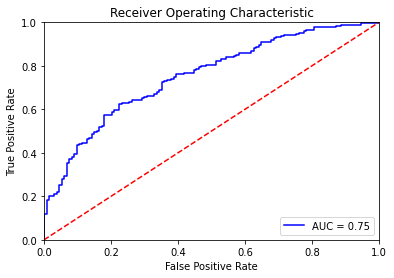

ROC AUC is 0.7519170204025742


In [144]:
fpr, tpr, threshold = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

print(f"ROC AUC is {roc_auc}")

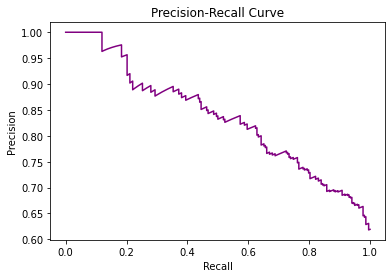

In [145]:
precision, recall, threshold = precision_recall_curve(y_test, y_score[:, 1])

fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
plt.show();

In [146]:
for value in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    idx = (np.abs(recall - value)).argmin() #index for recall
    result = np.where(precision == precision[idx]) # indexes for precision
    print(f"\nPrecision for recall = {value} is {precision[result]}")
    try:
      print(f"Threshold for recall = {value} is {threshold[result]}")
    except:
      print('none')


Precision for recall = 0.1 is [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]
none

Precision for recall = 0.2 is [0.91666667]
Threshold for recall = 0.2 is [0.50729855]

Precision for recall = 0.3 is [0.87837838]
Threshold for recall = 0.3 is [0.50602667]

Precision for recall = 0.4 is [0.87]
Threshold for recall = 0.4 is [0.50514522]

Precision for recall = 0.5 is [0.83206107]
Threshold for recall = 0.5 is [0.50382314]

Precision for recall = 0.6 is [0.8136646]
Threshold for recall = 0.6 is [0.50251721]

Precision for recall = 0.7 is [0.765]
Threshold for recall = 0.7 is [0.50138761]

Precision for recall = 0.8 is [0.72803347]
Threshold for recall = 0.8 is [0.5002132]

Precision for recall = 0.9 is [0.69257951]
Threshold for recall = 0.9 is [0.49868539]


              precision    recall  f1-score   support

           0       0.66      0.61      0.63       134
           1       0.77      0.80      0.79       218

    accuracy                           0.73       352
   macro avg       0.71      0.71      0.71       352
weighted avg       0.73      0.73      0.73       352



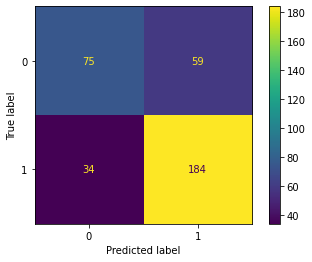

In [182]:
threshold = 0.5
y_pred_final = np.where(np.array(y_score[:, 1]) < threshold, 0, 1)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred_final)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [148]:
pd.DataFrame(y_pred_final).to_csv("/content/drive/MyDrive/Colab Notebooks/Project/y_pred_final.csv")
pd.DataFrame(y_pred).to_csv("/content/drive/MyDrive/Colab Notebooks/Project/y_pred.csv")

In [149]:
fp_indices = np.where((y_pred_final.reshape(-1,1)==1)&(y_test==0))
tp_indices = np.where((y_pred_final.reshape(-1,1)==1)&(y_test==1))

In [150]:
false_pos = path_test.loc[fp_indices[0], :]

In [151]:
true_pos = path_test.loc[tp_indices[0], :]

In [152]:
path_test.loc[fp_indices[0], :].to_csv('false_pos.csv')

In [153]:
path_test.loc[tp_indices[0], :].to_csv('true_pos.csv')

In [154]:
false_pos.head()

,id,model,Datetime,point,path,isgood
4,5db8cab9cfd88c21,Xiaomi Redmi Note 9 Pro | 10,2021-07-13 15:45:00,chest02,/content/drive/MyDrive/Colab Notebooks/Project...,1
9,79f88017a70a224f,Xiaomi Mi A2 | 10,2021-03-08 12:17:00,chest02,/content/drive/MyDrive/Colab Notebooks/Project...,0
18,b52431b003b7bb06,HUAWEI ANE-LX1 | 8.0.0,2021-05-03 13:42:00,chest01,/content/drive/MyDrive/Colab Notebooks/Project...,0
19,8a0a7454f0880e08,Xiaomi Redmi Note 9 Pro | 11,2021-11-07 18:31:00,chest04,/content/drive/MyDrive/Colab Notebooks/Project...,0
22,64f9c13f97eee760,Xiaomi Redmi Note 9 Pro | 11,2021-11-30 12:13:00,chest03,/content/drive/MyDrive/Colab Notebooks/Project...,1


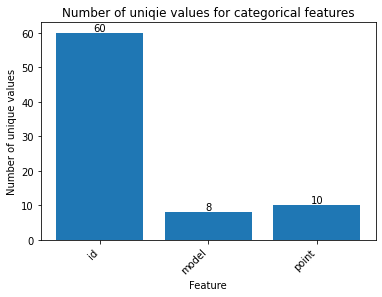

In [155]:
features = pd.DataFrame(false_pos[['id', 'model', 'point']].describe().loc['unique'])


fig, ax = plt.subplots()
bars = ax.bar(features.index, features['unique'])
ax.bar_label(bars)
plt.xlabel('Feature', )
plt.ylabel('Number of unique values')
plt.title('Number of uniqie values for categorical features')
plt.xticks(rotation=45, ha='right')
plt.show();

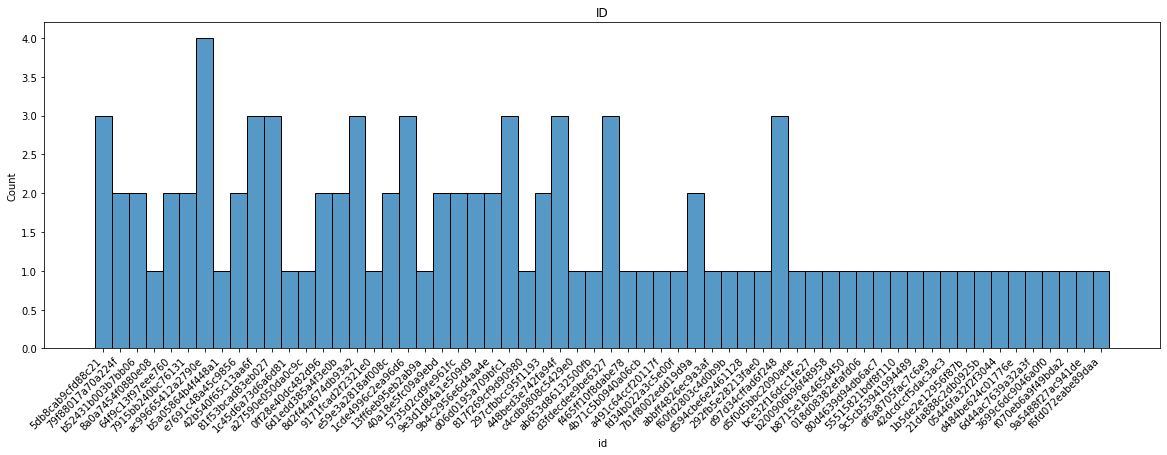

In [156]:
# define subplot grid
fig = plt.figure(figsize=(20, 6))
sns.histplot(false_pos['id'])
plt.title('ID')
ax.set_xlabel('id')
plt.xticks(rotation=45, ha='right')
plt.show();

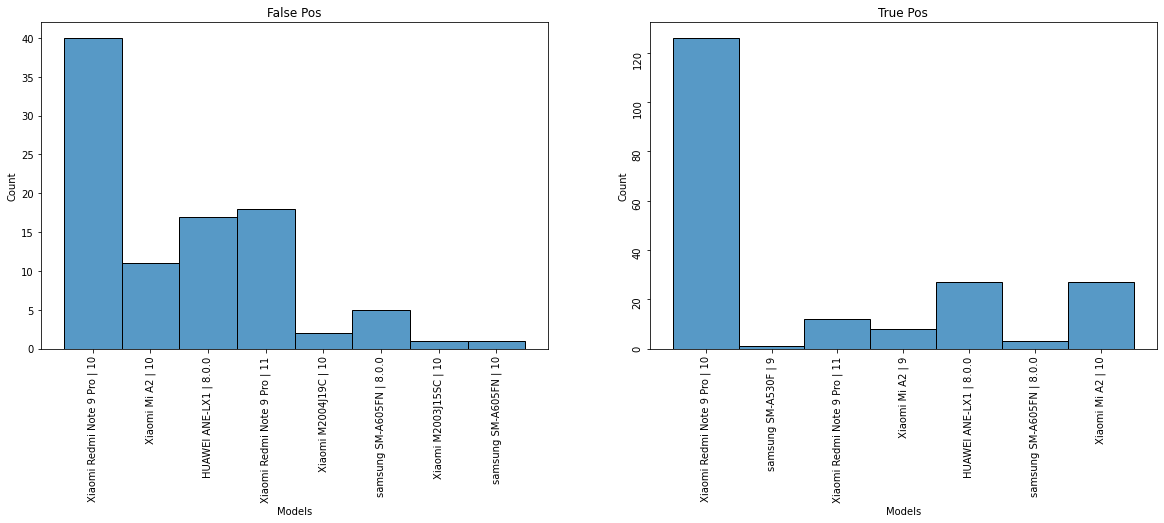

In [157]:

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

plt.title("Models for FP and TP", fontsize=18, y=1)

sns.histplot(false_pos['model'], ax=ax[0])
ax[0].set_title('False Pos')
ax[0].set_xlabel('Models')
ax[0].tick_params('x', rotation=90, left=True)
sns.histplot(true_pos['model'], ax=ax[1])
ax[1].set_title('True Pos')
ax[1].set_xlabel('Models')
ax[1].tick_params(rotation=90)
plt.show();

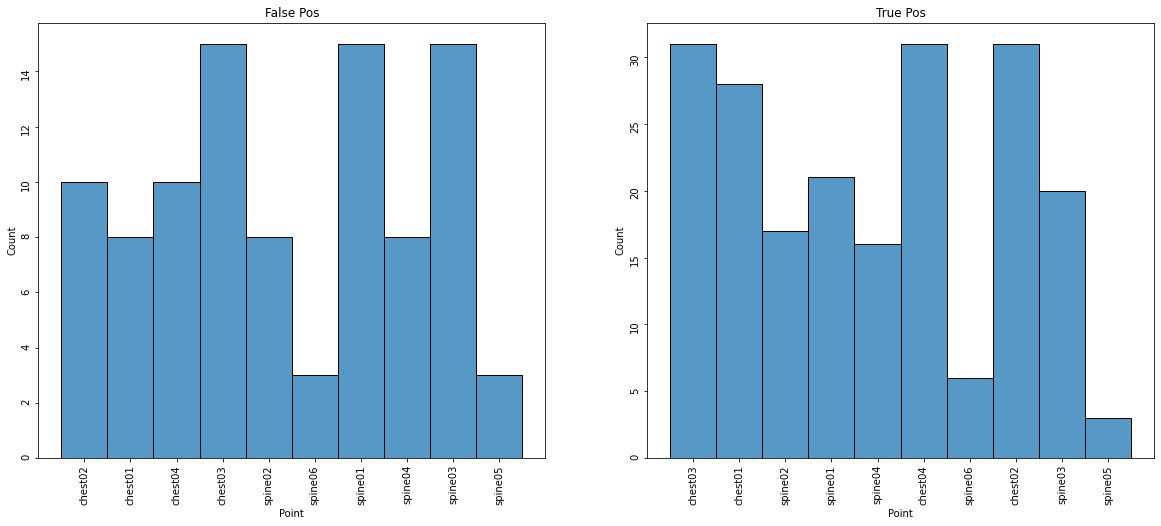

In [158]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

plt.title("Position for FP and TP", fontsize=18, y=1)

sns.histplot(false_pos['point'], ax=ax[0])
ax[0].set_title('False Pos')
ax[0].set_xlabel('Point')
ax[0].tick_params(rotation=90)
sns.histplot(true_pos['point'], ax=ax[1])
ax[1].set_title('True Pos')
ax[1].set_xlabel('Point')
ax[1].tick_params(rotation=90)
plt.show();

In [159]:
u_true, c_true = np.unique(true_pos['id'], return_counts=True)
u_false, c_false = np.unique(false_pos['id'], return_counts=True)

# Check which unique elements are common in both arrays
print('Ids intersect in', np.intersect1d(u_true,u_false))

Ids intersect in ['1c45d6a73d6a6d81' '80d4639d94db6ac7' '817f269cf9d90980'
 '9c5cb53941994489' 'a491c64ccf20117f' 'abbff4826ec9a3af'
 'b5a05864b4f448a1' 'd594cbe6e2461128']


In [160]:
u_true_model, c_true_model = np.unique(true_pos['model'], return_counts=True)
u_false_model, c_false_model = np.unique(false_pos['model'], return_counts=True)

# Check which unique elements are common in both arrays
print('Models intersect in', np.intersect1d(u_true_model,u_false_model), 'counts are: ', c_true_model[np.intersect1d(u_true_model,u_false_model, return_indices=True)[1]])

Models intersect in ['HUAWEI ANE-LX1 | 8.0.0' 'Xiaomi Mi A2 | 10'
 'Xiaomi Redmi Note 9 Pro | 10' 'Xiaomi Redmi Note 9 Pro | 11'
 'samsung SM-A605FN | 8.0.0'] counts are:  [ 27  27 126  12   3]


In [161]:
df1_model = pd.DataFrame(np.intersect1d(u_true_model,u_false_model), columns=['model'])
df2_model = pd.DataFrame(c_true_model[np.intersect1d(u_true_model,u_false_model, return_indices=True)[1]], columns=['count'])

In [162]:
df_model = pd.concat([df1_model, df2_model], axis=1)

In [163]:
print('these models are showing FP and TP')
df_model

these models are showing FP and TP


,model,count
0,HUAWEI ANE-LX1 | 8.0.0,27
1,Xiaomi Mi A2 | 10,27
2,Xiaomi Redmi Note 9 Pro | 10,126
3,Xiaomi Redmi Note 9 Pro | 11,12
4,samsung SM-A605FN | 8.0.0,3


In [164]:
diff_true_model = np.setdiff1d(u_true_model,u_false_model)
print('These models are only showing True' ,diff_true_model)

diff_false_model = np.setdiff1d(u_false_model, u_true_model)
print('These models are only showing False' ,diff_false_model)

These models are only showing True ['Xiaomi Mi A2 | 9' 'samsung SM-A530F | 9']
These models are only showing False ['Xiaomi M2003J15SC | 10' 'Xiaomi M2004J19C | 10' 'samsung SM-A605FN | 10']


In [165]:
false_pos[false_pos['model'].isin(diff_false_model)]

,id,model,Datetime,point,path,isgood
53,0ff28e40dc482d96,Xiaomi M2004J19C | 10,2021-10-29 21:30:00,spine01,/content/drive/MyDrive/Colab Notebooks/Project...,0
255,0ff28e40dc482d96,Xiaomi M2004J19C | 10,2021-10-29 21:30:00,spine06,/content/drive/MyDrive/Colab Notebooks/Project...,0
291,42dcdccf5dac3ac3,Xiaomi M2003J15SC | 10,2021-12-15 19:58:00,chest03,/content/drive/MyDrive/Colab Notebooks/Project...,0
344,f070eb6a9f49bda2,samsung SM-A605FN | 10,2020-09-14 17:19:00,spine03,/content/drive/MyDrive/Colab Notebooks/Project...,0


In [166]:
true_pos[true_pos['model'].isin(diff_true_model)]

,id,model,Datetime,point,path,isgood
2,21a36ba2a1ad0629,samsung SM-A530F | 9,2020-10-08 09:01:00,chest03,/content/drive/MyDrive/Colab Notebooks/Project...,2
11,044fcd19b99d542d,Xiaomi Mi A2 | 9,2020-03-18 10:52:00,chest01,/content/drive/MyDrive/Colab Notebooks/Project...,0
20,397d9b5f03641a39,Xiaomi Mi A2 | 9,2020-02-21 10:09:00,chest01,/content/drive/MyDrive/Colab Notebooks/Project...,0
27,044fcd19b99d542d,Xiaomi Mi A2 | 9,2020-03-18 10:52:00,chest03,/content/drive/MyDrive/Colab Notebooks/Project...,0
65,13e177541e7ebb1a,Xiaomi Mi A2 | 9,2020-03-10 13:01:00,spine01,/content/drive/MyDrive/Colab Notebooks/Project...,0
91,eb50ca6be66b8aff,Xiaomi Mi A2 | 9,2020-03-11 11:21:00,chest03,/content/drive/MyDrive/Colab Notebooks/Project...,0
248,13e177541e7ebb1a,Xiaomi Mi A2 | 9,2020-03-10 13:01:00,spine03,/content/drive/MyDrive/Colab Notebooks/Project...,0
310,13e177541e7ebb1a,Xiaomi Mi A2 | 9,2020-03-10 13:01:00,spine02,/content/drive/MyDrive/Colab Notebooks/Project...,0
334,eb50ca6be66b8aff,Xiaomi Mi A2 | 9,2020-03-11 11:21:00,chest02,/content/drive/MyDrive/Colab Notebooks/Project...,0


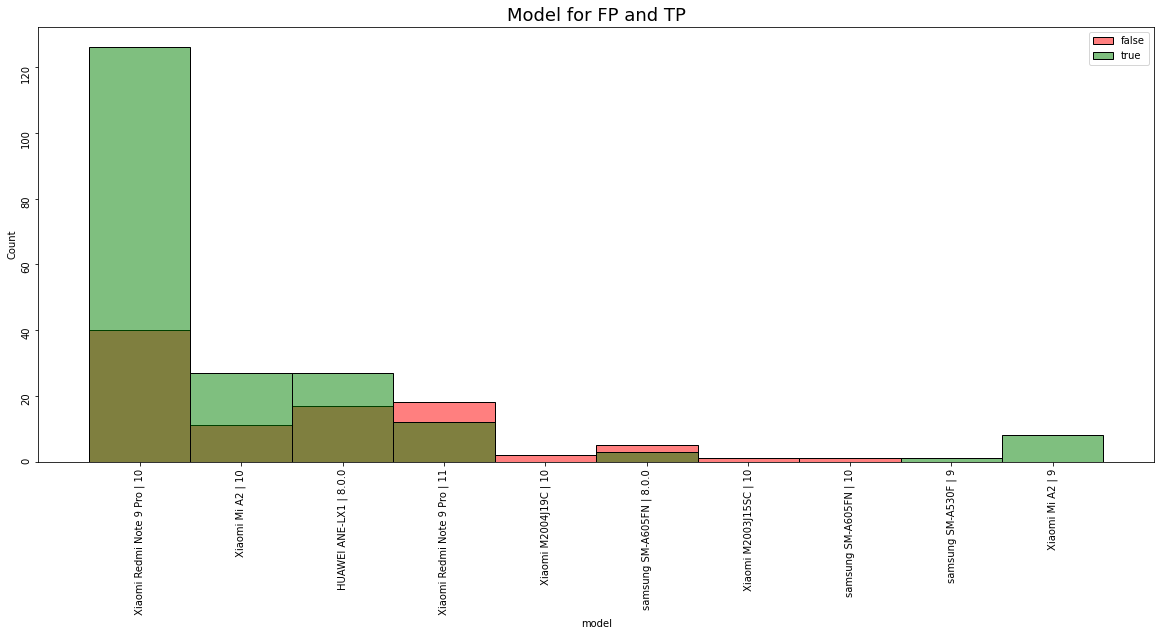

In [167]:
fig = plt.figure(figsize=(20, 8))

plt.title("Model for FP and TP", fontsize=18, y=1)

sns.histplot(false_pos['model'], alpha=0.5, color='r', label='false')
sns.histplot(true_pos['model'], alpha=0.5, color='g', label='true')

plt.legend()
plt.tick_params(rotation=90)
plt.show();

In [168]:
u_true_point, c_true_point = np.unique(true_pos['point'], return_counts=True)
u_false_point, c_false_point = np.unique(false_pos['point'], return_counts=True)

# Check which unique elements are common in both arrays
print('Models intersect in', np.intersect1d(u_true_point,u_false_point), 'counts are: ', c_true_point[np.intersect1d(u_true_point,u_false_point, return_indices=True)[1]])

Models intersect in ['chest01' 'chest02' 'chest03' 'chest04' 'spine01' 'spine02' 'spine03'
 'spine04' 'spine05' 'spine06'] counts are:  [28 31 31 31 21 17 20 16  3  6]


In [169]:
df1_point = pd.DataFrame(np.intersect1d(u_true_point,u_false_point), columns=['point'])
df2_point = pd.DataFrame(c_true_point[np.intersect1d(u_true_point,u_false_point, return_indices=True)[1]], columns=['count'])

In [170]:
df_point = pd.concat([df1_point, df2_point], axis=1)

In [171]:
print('these points are showing FP and TP')
df_point

these points are showing FP and TP


,point,count
0,chest01,28
1,chest02,31
2,chest03,31
3,chest04,31
4,spine01,21
5,spine02,17
6,spine03,20
7,spine04,16
8,spine05,3
9,spine06,6


In [172]:
diff_true_point = np.setdiff1d(u_true_point,u_false_point)
print('These models are only showing True' ,diff_true_point)

diff_false_point = np.setdiff1d(u_false_point, u_true_point)
print('These models are only showing False' ,diff_false_point)

These models are only showing True []
These models are only showing False []


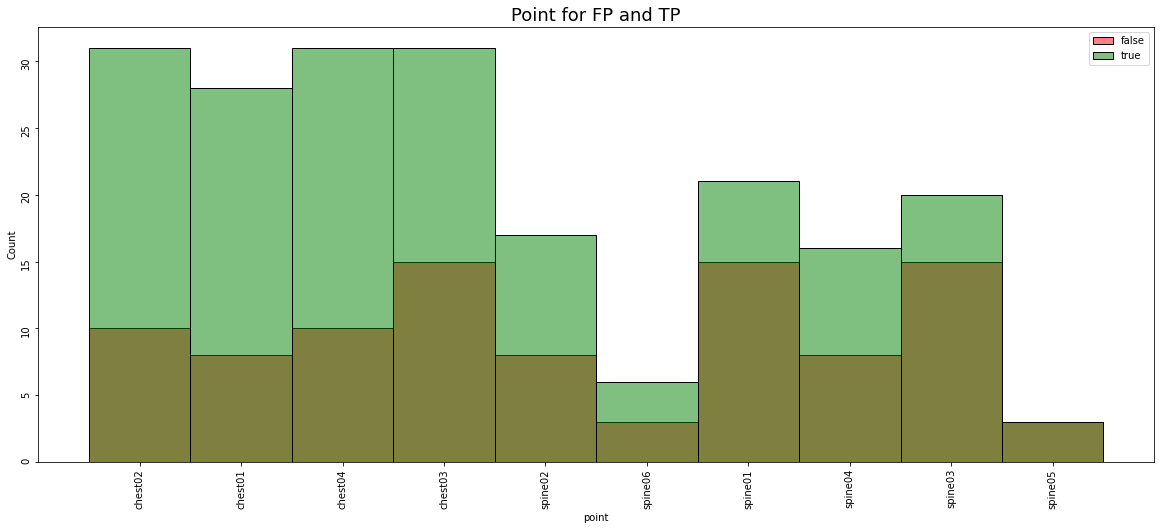

In [173]:
fig = plt.figure(figsize=(20, 8))

plt.title("Point for FP and TP", fontsize=18, y=1)

sns.histplot(false_pos['point'], alpha=0.5, color='r', label='false')
sns.histplot(true_pos['point'], alpha=0.5, color='g', label='true')

plt.legend()
plt.tick_params(rotation=90)
plt.show();

In [174]:
X_train.columns

Index(['log_melspec_mean_1', 'log_melspec_mean_2', 'log_melspec_mean_3',
       'log_melspec_mean_4', 'log_melspec_mean_5', 'log_melspec_mean_6',
       'log_melspec_mean_7', 'log_melspec_mean_8', 'log_melspec_mean_9',
       'log_melspec_mean_10',
       ...
       'log_melspec_std_57', 'log_melspec_std_58', 'log_melspec_std_59',
       'log_melspec_std_60', 'log_melspec_std_61', 'log_melspec_std_62',
       'log_melspec_std_63', 'log_melspec_std_64',
       'loudness_slidingwindow_mean', 'loudness_slidingwindow_std'],
      dtype='object', length=130)

In [176]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                    test_size=0.2 ,random_state=99)

In [177]:
from sklearn.svm import SVC
for kernel in  ['linear', 'poly', 'rbf', 'sigmoid']:
  classifier_SVM = SVC(kernel = kernel, probability=True)
  classifier_SVM.fit(X_train, y_train)
  y_pred = classifier_SVM.predict(X_val)
  y_score = classifier_SVM.predict_proba(X_val)
  print(f"Accuracy for kernel {kernel} is  {accuracy_score(y_val, y_pred)}")


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy for kernel linear is  0.7829181494661922


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy for kernel poly is  0.6583629893238434


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy for kernel rbf is  0.6548042704626335


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy for kernel sigmoid is  0.6476868327402135


In [178]:
X_train = pd.concat([X_train, X_val], axis=0)
y_train = pd.concat([y_train, y_val], axis=0)

In [179]:
classifier_SVM = SVC(kernel = 'linear', probability=True)
classifier_SVM.fit(X_train, y_train)
y_pred = classifier_SVM.predict(X_test)
y_score = classifier_SVM.predict_proba(X_test)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


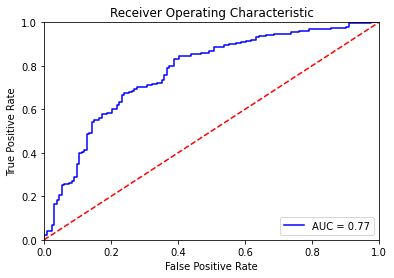

ROC AUC is 0.7697521566479529


In [180]:
fpr, tpr, threshold = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

print(f"ROC AUC is {roc_auc}")

              precision    recall  f1-score   support

           0       0.66      0.61      0.63       134
           1       0.77      0.80      0.79       218

    accuracy                           0.73       352
   macro avg       0.71      0.71      0.71       352
weighted avg       0.73      0.73      0.73       352



array([[ 57,  77],
       [ 22, 196]])

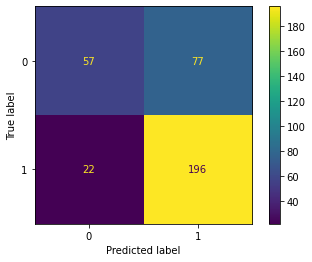

In [191]:
threshold = 0.4
y_pred_final = np.where(np.array(y_score[:, 1]) < threshold, 0, 1)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred_final)
display(cm)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();